In [158]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split

### Loading Data

In [159]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
dataFolder = os.path.join(parentFolder, 'Data')
allImagesFolder = os.path.join(dataFolder, 'all')

In [160]:
labels = []

for filename in os.listdir(allImagesFolder):
    if filename.endswith(".xml"):
        filepath = os.path.join(allImagesFolder, filename)
        xml = ET.parse(filepath)
        annot = xml.getroot()
        fName = annot.find('filename').text
        size = annot.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        if width<40 or height<40 or width >999999 or height> 999999:
            continue
        
        objects = annot.findall('object')
        if len(objects)!=1:
            pass
        elif objects[0].find('name').text=='pothole':
            box = objects[0].find('bndbox')
            
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            
            if xmin<0 or xmax>width or ymin<0 or ymax>height:
                continue
            
            labels.append([fName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])


In [161]:
labelDf.describe()

,width,height,xmin,ymin,xmax,ymax
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,831.460784,549.049020,201.191176,225.813725,644.833333,430.352941
std,528.261414,338.804429,192.924007,202.858306,397.470811,284.671088
min,200.000000,129.000000,1.000000,12.000000,116.000000,77.000000
25%,534.750000,358.000000,71.000000,105.000000,386.500000,261.500000
50%,700.000000,470.500000,150.000000,184.000000,567.000000,360.500000
75%,980.000000,636.000000,283.250000,275.500000,750.250000,520.000000
max,4032.000000,3024.000000,1328.000000,1611.000000,2309.000000,2211.000000


In [162]:
labelDf.isnull().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [163]:
newSize = (128, 128)

labelDf.xmin = labelDf.xmin/labelDf.width
labelDf.xmax = labelDf.xmax/labelDf.width
labelDf.ymin = labelDf.ymin/labelDf.height
labelDf.ymax = labelDf.ymax/labelDf.height

In [164]:
labelDf.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,101.jpg,600,400,pothole,0.253333,0.762500,0.450000,0.870000
1,109.jpg,720,478,pothole,0.272222,0.437238,0.626389,0.650628
2,117.jpg,240,135,pothole,0.212500,0.385185,0.791667,0.733333
3,12.jpg,534,401,pothole,0.013109,0.518703,0.919476,0.997506
4,120.jpg,300,199,pothole,0.350000,0.190955,0.840000,0.638191


In [165]:
labelDf['w'] = labelDf.xmax - labelDf.xmin
labelDf['h'] = labelDf.ymax - labelDf.ymin

In [166]:
def retrieveImage(fName):
    fPath = os.path.join(allImagesFolder, fName)
    pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
    return pic

In [167]:
X = np.array(labelDf.filename.apply(retrieveImage).tolist())



In [168]:
Y = labelDf[['xmin', 'ymin', 'w', 'h']].to_numpy()
Y.shape

(204, 4)

In [169]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

In [170]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(163, 128, 128, 3)
(163, 4)
(41, 128, 128, 3)
(41, 4)


In [171]:
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256, (2,2), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('linear'))



In [172]:
model.compile(optimizer= 'adam', loss='mean_absolute_error')

In [173]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=20)

Train on 163 samples, validate on 41 samples
Epoch 1/20
163/163 [==============================] - 2s 10ms/sample - loss: 0.3293 - val_loss: 0.2550
Epoch 2/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.2880 - val_loss: 0.1878
Epoch 3/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1882 - val_loss: 0.1505
Epoch 4/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1660 - val_loss: 0.1483
Epoch 5/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1606 - val_loss: 0.1566
Epoch 6/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1568 - val_loss: 0.1585
Epoch 7/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1531 - val_loss: 0.1602
Epoch 8/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1510 - val_loss: 0.1451
Epoch 9/20
163/163 [==============================] - 0s 2ms/sample - loss: 0.1509 - val_loss: 0.1540
Epoch 10/20
163/163 [===============

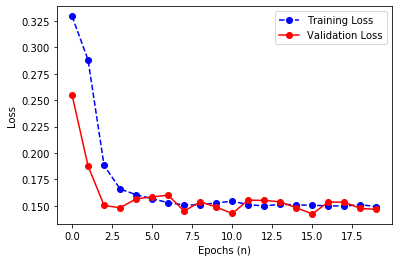

In [174]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

(40.24539877300614, 32.61939239501953)
(82.31062670299727, 48.11159133911133)
(70.47852760736197, 65.42234802246094)
(17.438692098092645, 46.42399597167969)


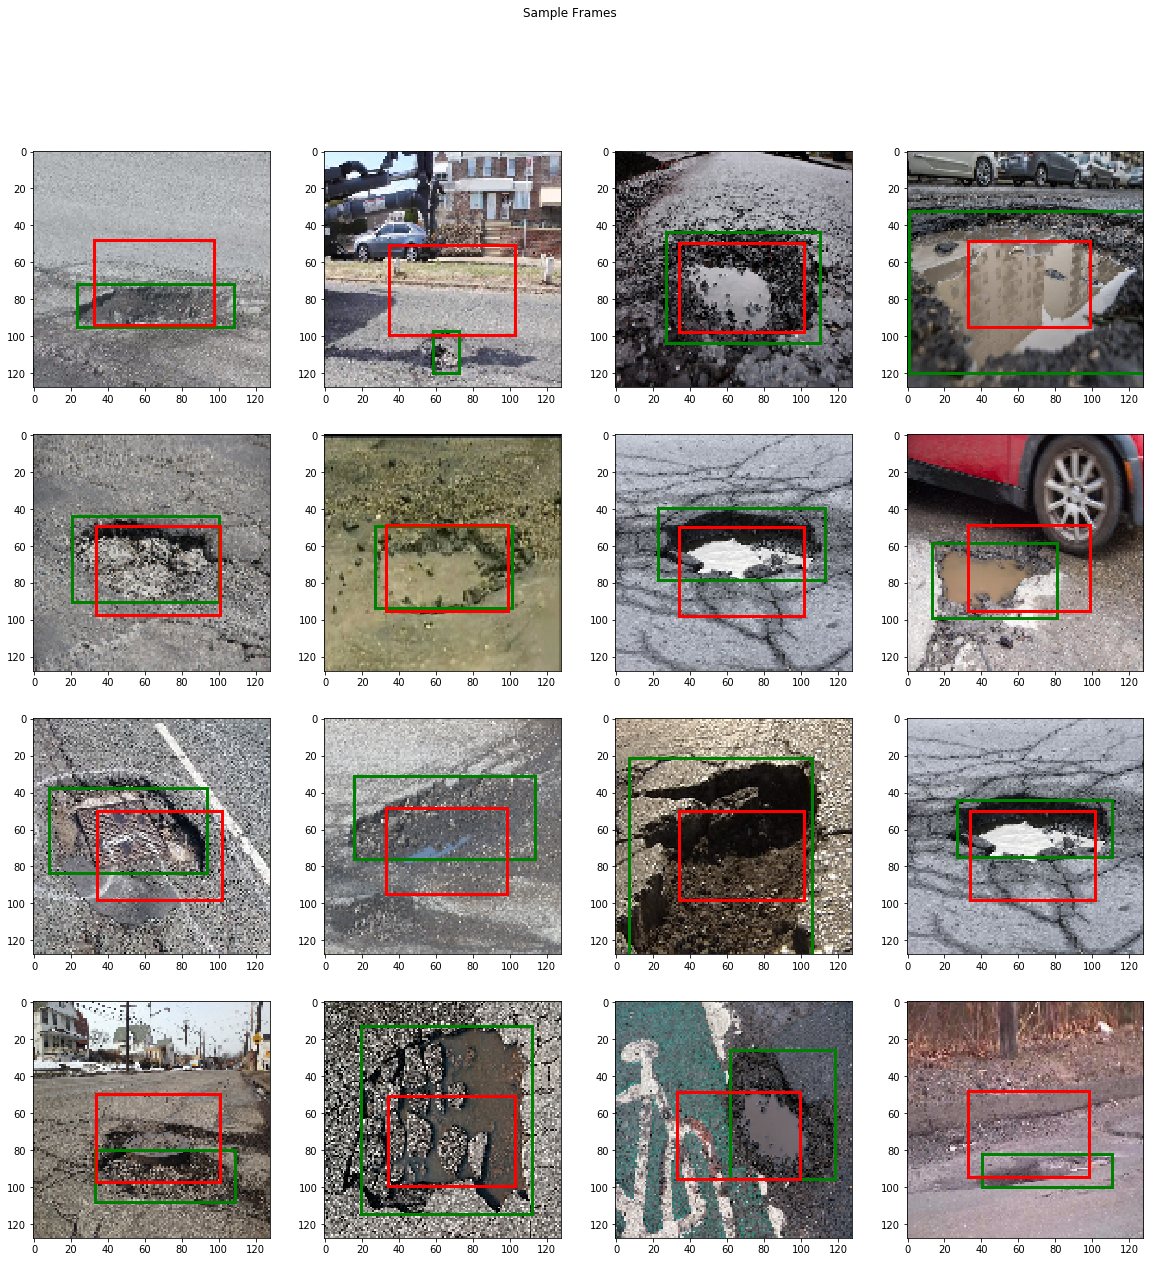

In [176]:
shift = 4
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_train[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_train[20+imgNum + shift])
    
    
    [x,y,w,h] = Y_train[20+imgNum + shift]
    [[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_train[20+imgNum + shift], axis=0))
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]

    x1= x1*newSize[0]
    y1= y1*newSize[1]
    w1= w1*newSize[0]
    h1= h1*newSize[1]

    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect)
    rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 3, edgecolor='r', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))